# 👨‍💻 Let's Code ARIMA

In the last notebook we saw how the ARIMA is interconnected... or say what happens in the ARIMA. Now, it is time to see that in action. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 10)

from statsmodels.tsa.arima.model import ARIMA

# optional
import warnings
warnings.filterwarnings("ignore")

To start with the ***understanding*** of how ARIMA behaves, and also the different combinations of the parameters... we will *first see the old — airline* data and then will see the stock prices.

In [2]:
df = pd.read_csv("../data/airline_passengers.csv", index_col=0, parse_dates=True)
df.index.freq = "MS"
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [3]:
train = df.iloc[:-12]
test = df.iloc[-12:]

Sou, our data is...

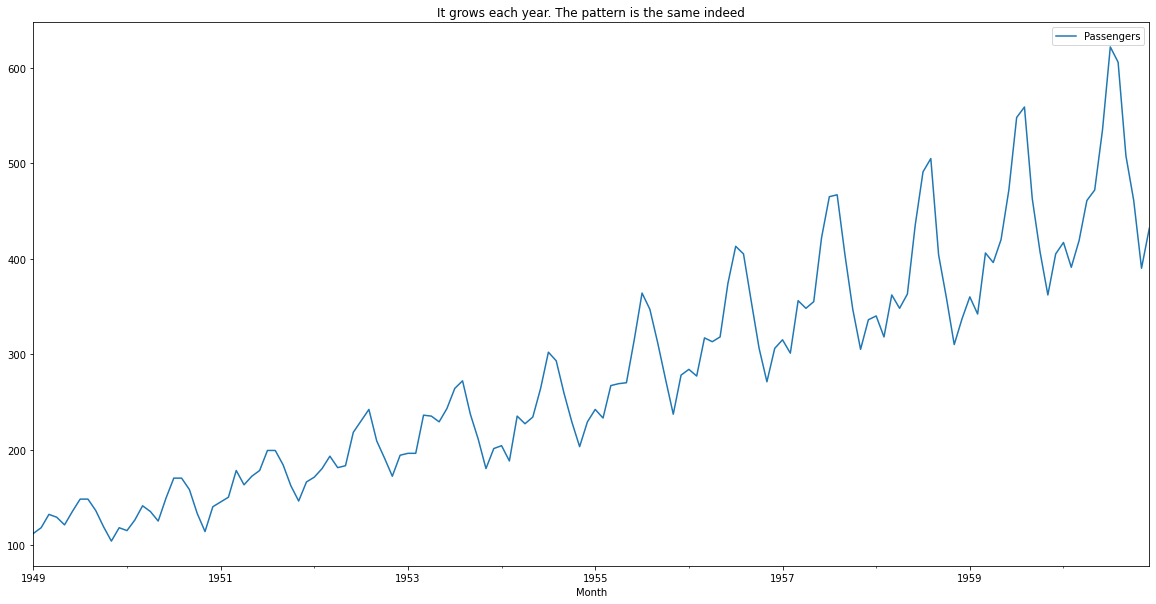

In [4]:
df.plot()
plt.title("It grows each year. The pattern is the same indeed");

#### First off, let's see how it behaves with our simple model `ARIMA(1, 0, 0)` which means:
> The upcoming value only depends on the previous value. Just like the random-walk model. `AR(1)`.

In [5]:
model = ARIMA(train, order=(1, 0, 0))

In [6]:
result = model.fit()

The `result.forecast` will return simple forecast. 

But, this time we will need the following 3 things: 
1. Real forecast
2. Std Error
3. Confidence interval

To have them we will haveto use the `result.get_forecast` and the object that is returned will contain those 3 things.<br>
So, we will use `1.` and `3.` to show in the plot.

In [7]:
# simply the forecast values
result.forecast(12)

1960-01-01    399.554855
1960-02-01    394.317763
1960-03-01    389.280774
1960-04-01    384.436243
1960-05-01    379.776815
1960-06-01    375.295420
1960-07-01    370.985253
1960-08-01    366.839773
1960-09-01    362.852687
1960-10-01    359.017943
1960-11-01    355.329721
1960-12-01    351.782421
Freq: MS, Name: predicted_mean, dtype: float64

In [8]:
forecast_results = result.get_forecast(12)

In [9]:
# the real forecast 
forecasts = forecast_results.predicted_mean
forecasts

1960-01-01    399.554855
1960-02-01    394.317763
1960-03-01    389.280774
1960-04-01    384.436243
1960-05-01    379.776815
1960-06-01    375.295420
1960-07-01    370.985253
1960-08-01    366.839773
1960-09-01    362.852687
1960-10-01    359.017943
1960-11-01    355.329721
1960-12-01    351.782421
Freq: MS, Name: predicted_mean, dtype: float64

In [10]:
# the conf interval 
conf_interval = forecast_results.conf_int()
conf_interval

,lower Passengers,upper Passengers
1960-01-01,338.658210,460.451500
1960-02-01,309.826171,478.809354
1960-03-01,287.732168,490.829379
1960-04-01,269.338256,499.534230
1960-05-01,253.432284,506.121347
1960-06-01,239.373402,511.217437
1960-07-01,226.768868,515.201638
1960-08-01,215.354570,518.324977
1960-09-01,204.941150,520.764224
1960-10-01,195.386337,522.649550


In [11]:
forecasts = pd.Series(forecasts, index=test.index)

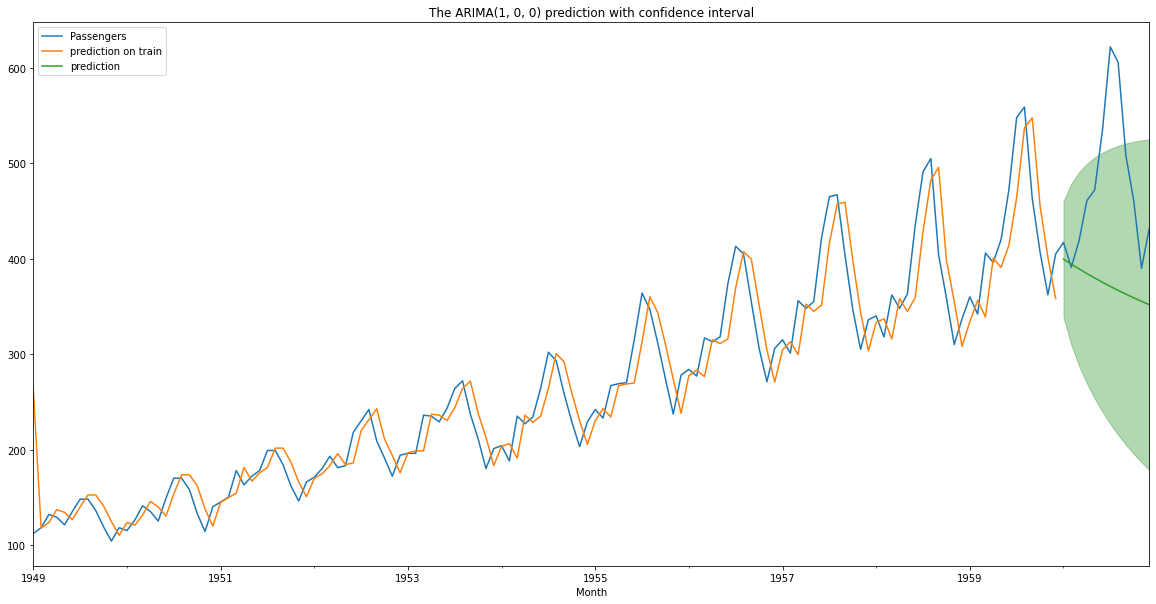

In [12]:
df.plot(label="real data")
result.predict(train.index[0], train.index[-1]).plot(label="prediction on train")
forecasts.plot(label="prediction")
plt.fill_between(forecasts.index, 
                 conf_interval.iloc[:, 0],
                 conf_interval.iloc[:, 1],
                 alpha=0.3,
                 color="green")

plt.legend()
plt.title("The ARIMA(1, 0, 0) prediction with confidence interval");

Mesmarizing? <br>
Nah, but the thing is that **it has only run on single past value**. So, it has to act werid. The *wierder* thing is that, dispite of overall upward trend, it is showing the down trend! How foolish!

But still, **if you look closely** the value had to drop once. As per the season, the value ther should drop and then rise. Try to analyze.

##### 

### 🤔 Other set of parameters? 
Sure, but first let's make a function to do the same job again and again. 

In [13]:
def get_and_plot(result, h, title=None, original_data=None):
    """
    This function will take the result and then from the learnd values,
    it will make forecast (in-sample and out-sample).
    
    Then it will plot the result!
    """
    forecast_result = result.get_forecast(h)
    forecast_index = pd.date_range(test.index[0], periods=h, freq="MS")
    pred = forecast_result.predicted_mean
    pred = pd.Series(pred, index=forecast_index)
    conf_int = forecast_result.conf_int()
    

    # doing this so that we can pass data with other scale
    # that will come below once we will reach at the "trans
    # -formation section in this book.
    if isinstance(original_data, pd.DataFrame):
        original_data.plot()
    else:
        df.plot(label="real data")
        
    # [1:] because fittedvalues will have very first values as 0.00
    result.fittedvalues[1:].plot(label="prediction on train")
    pred.plot(label="prediction")
    plt.fill_between(pred.index, 
                     conf_int.iloc[:, 0],
                     conf_int.iloc[:, 1],
                     alpha=0.2,
                     color="green")

    plt.legend()
    if title:
        plt.title(title);
    else:
        plt.title("The prediction with confidence interval");

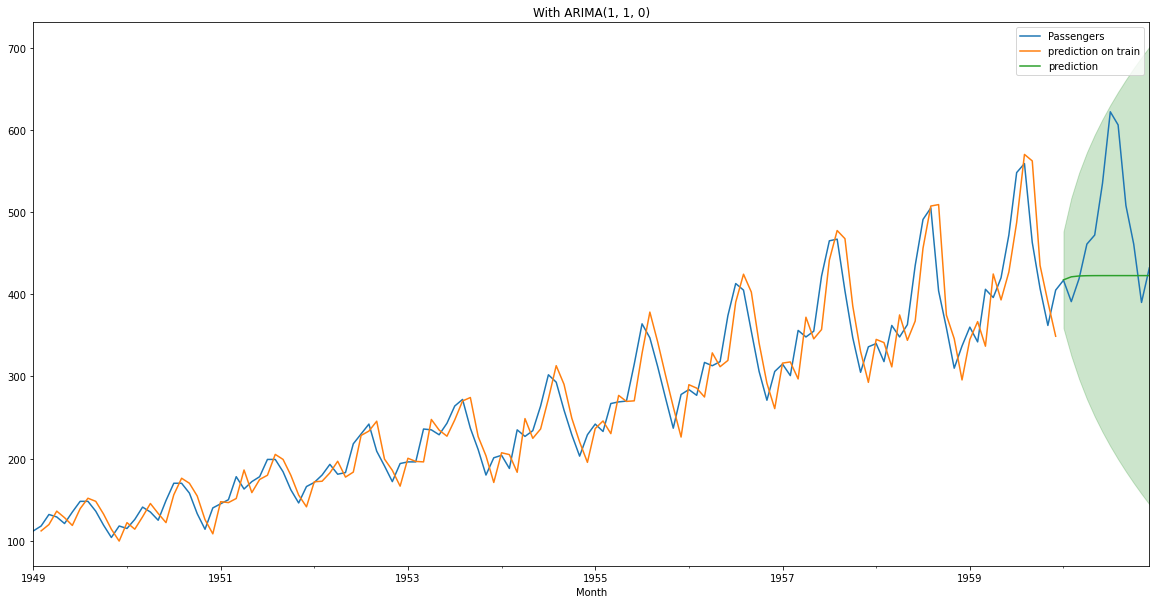

In [14]:
arima_110 = ARIMA(train, order=(1, 1, 0))
result_110 = arima_110.fit()
get_and_plot(result_110, 12, "With ARIMA(1, 1, 0)")

This plot can confirm that differenciancing can cause the time-series to be more flat... here we have taken `d=1`.

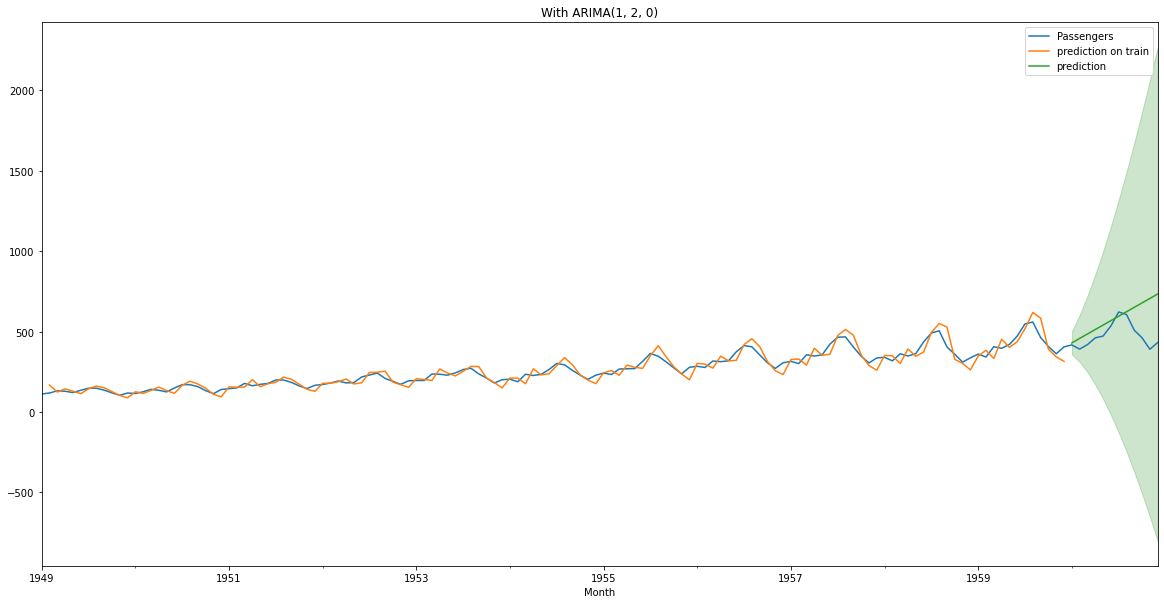

In [15]:
arima_120 = ARIMA(train, order=(1, 2, 0))
result_120 = arima_120.fit()
get_and_plot(result_120, 12, "With ARIMA(1, 2, 0)")

Differencing more will cause values to fluctuate more!

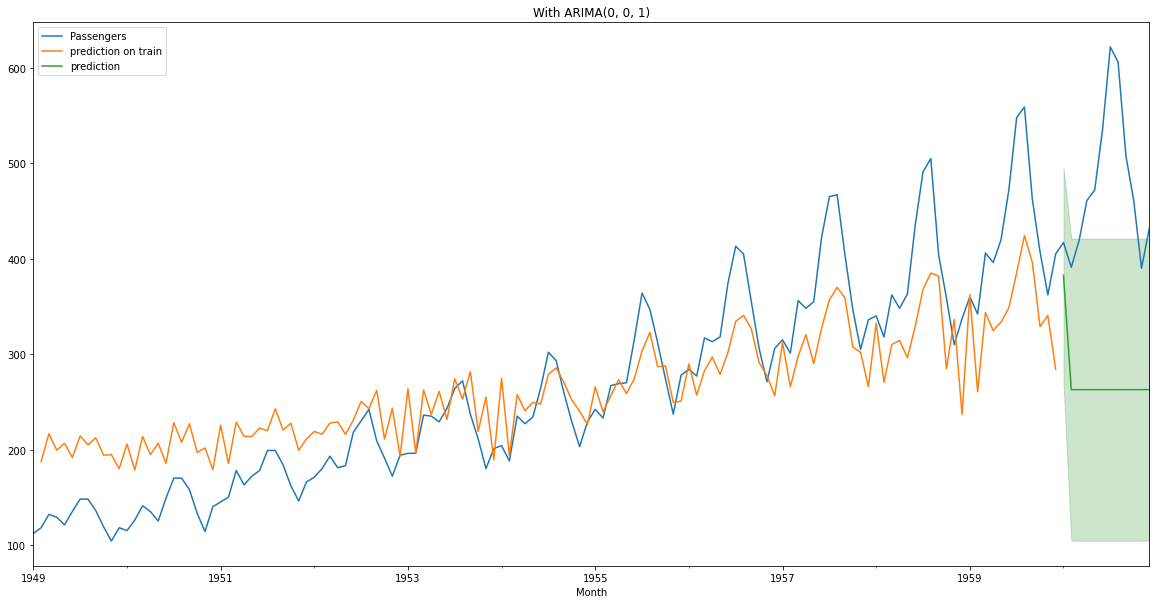

In [16]:
arima_001 = ARIMA(train, order=(0, 0, 1)) #MA(1)
result_001 = arima_001.fit()
get_and_plot(result_001, 12, "With ARIMA(0, 0, 1)")

This model means we are only depending on the past single error... and that is much much worse!

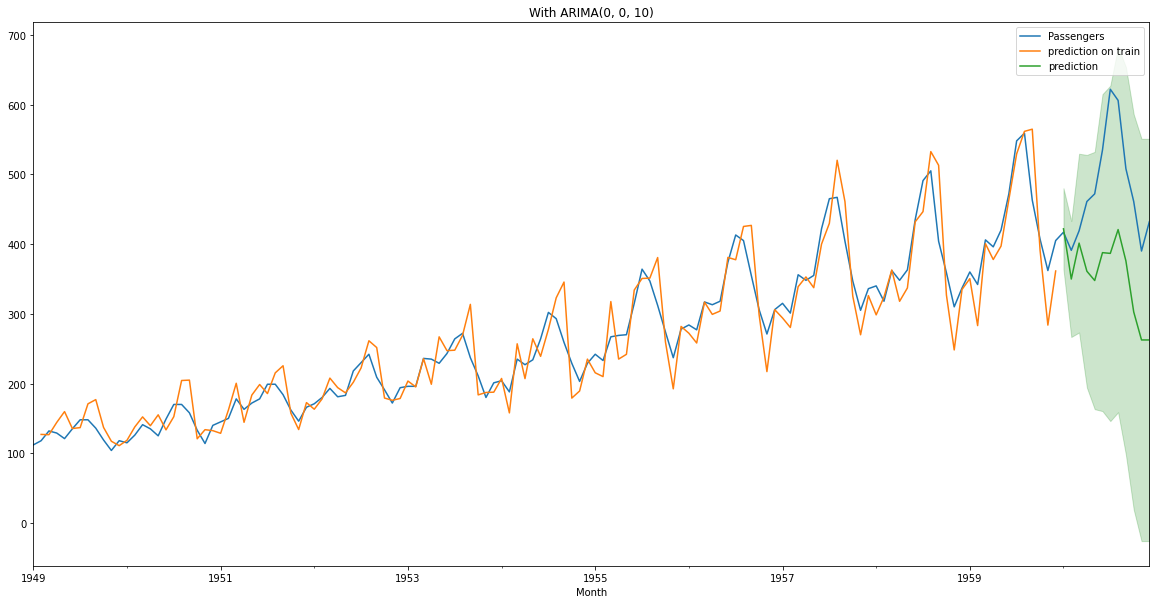

In [17]:
arima_0010 = ARIMA(train, order=(0, 0, 10))
result_0010 = arima_0010.fit()
get_and_plot(result_0010, 12, "With ARIMA(0, 0, 10)")

Depending on the past 10 errors is doing some better predictions... but still not what I want.

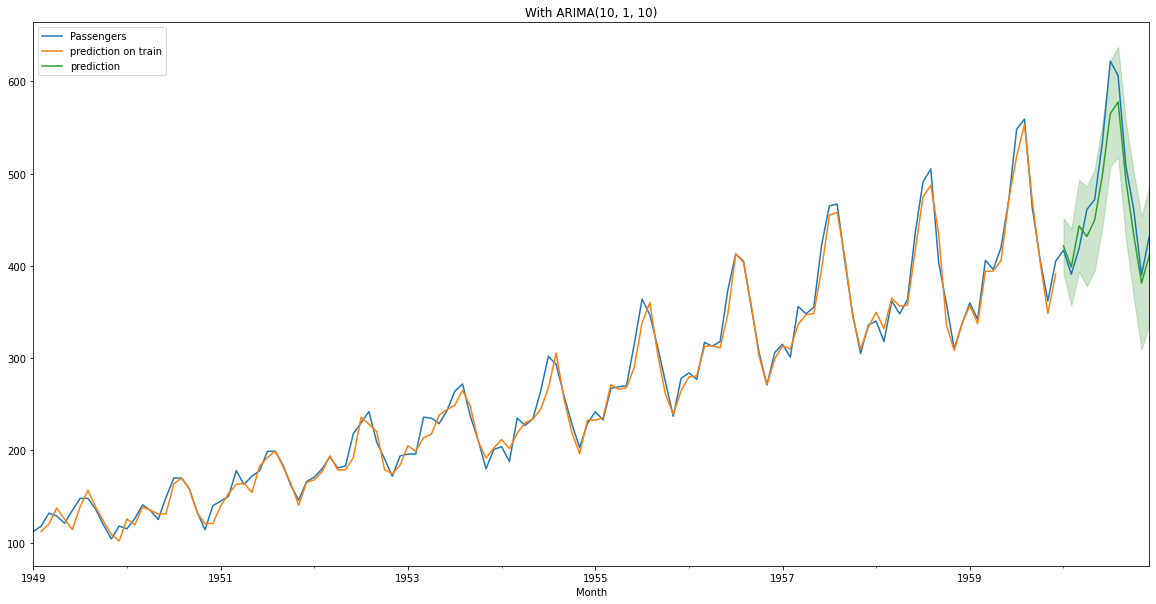

In [18]:
arima_10110 = ARIMA(train, order=(10, 1, 10))
result_10110 = arima_10110.fit()
get_and_plot(result_10110, 12, "With ARIMA(10, 1, 10)")

Oh! Much better isn't it? Like that's what we have to see... I have tried to follow the natural pattern here. Our data repeats after 12 months *(yeah here I have takeon only 10 but will see)* and so have treid to keep them as it is.

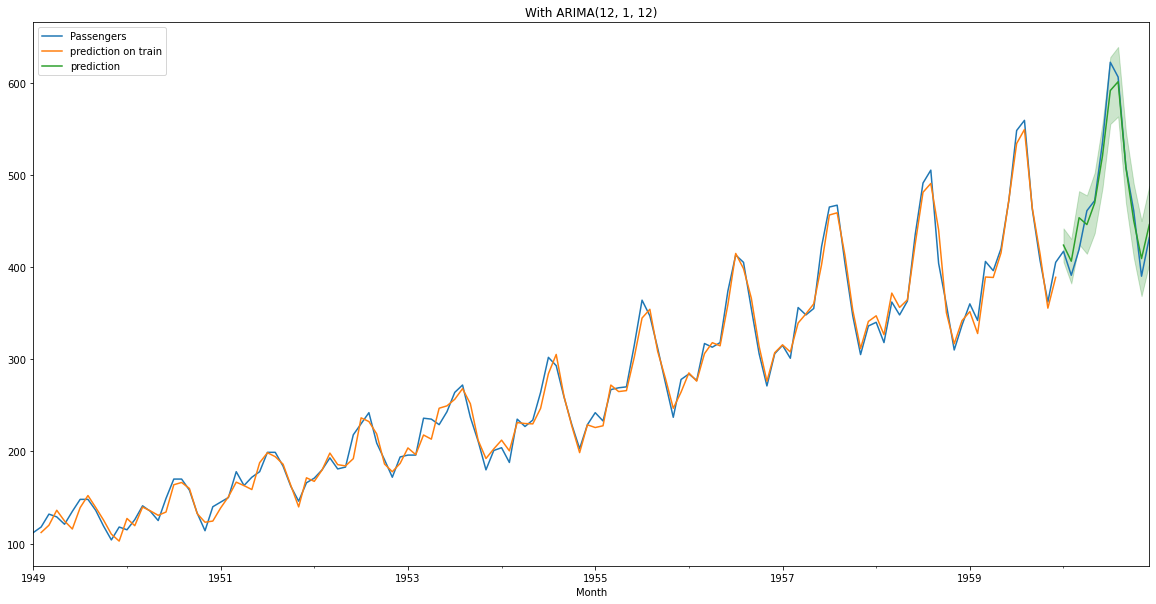

In [19]:
arima_12112 = ARIMA(train, order=(12, 1, 12))
result_12112 = arima_12112.fit()
get_and_plot(result_12112, 12, "With ARIMA(12, 1, 12)")

The **best** so far! And if we ***stretch*** it to the further future... then...

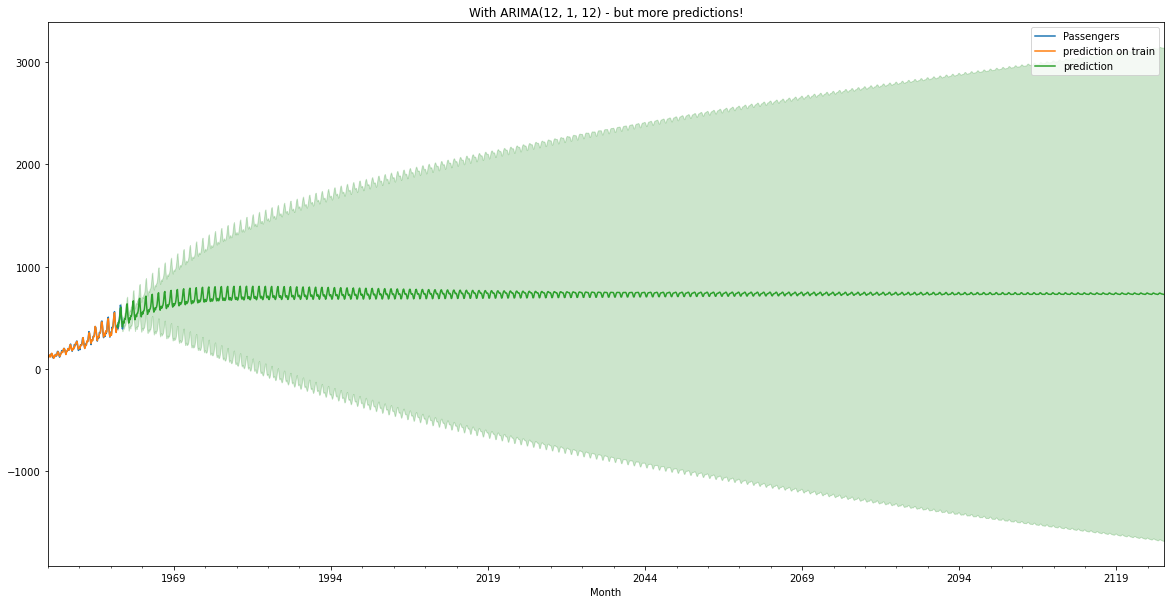

In [20]:
get_and_plot(result_12112, 2000, "With ARIMA(12, 1, 12) - but more predictions!")

The "confidence interval gets larger" and the predictions start becoming flatter. Thus, predicting more... will not make sence apart from *2x* or *max 3x* of a set period.

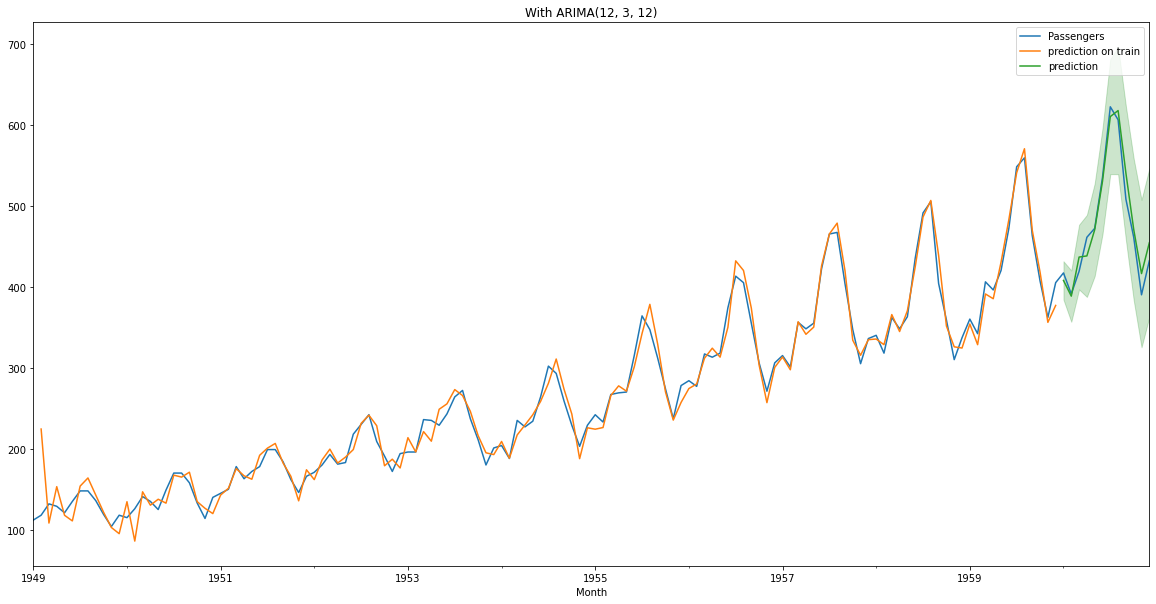

In [21]:
arima_12312 = ARIMA(train, order=(12, 3, 12))
result_12312 = arima_12312.fit()
get_and_plot(result_12312, 12, "With ARIMA(12, 3, 12)")

Differencing made life much easier! Dude! But as said: ***"Don't mess with differencing more. It should not be more than 2"***.

# 

## 🧮 Which model is better?
Here we can simply go for RMSE function... but before that I want to tell you something.

> Recall, that in the first/early notebooks we have learnt about the *transformations*. They are the things which will make difference here. 

Ask **why**? <br>
Because, ***differencing doesn't change the amplification of values as much as the classic transformations do.***

What? What do I mean?<br>
See the example below.

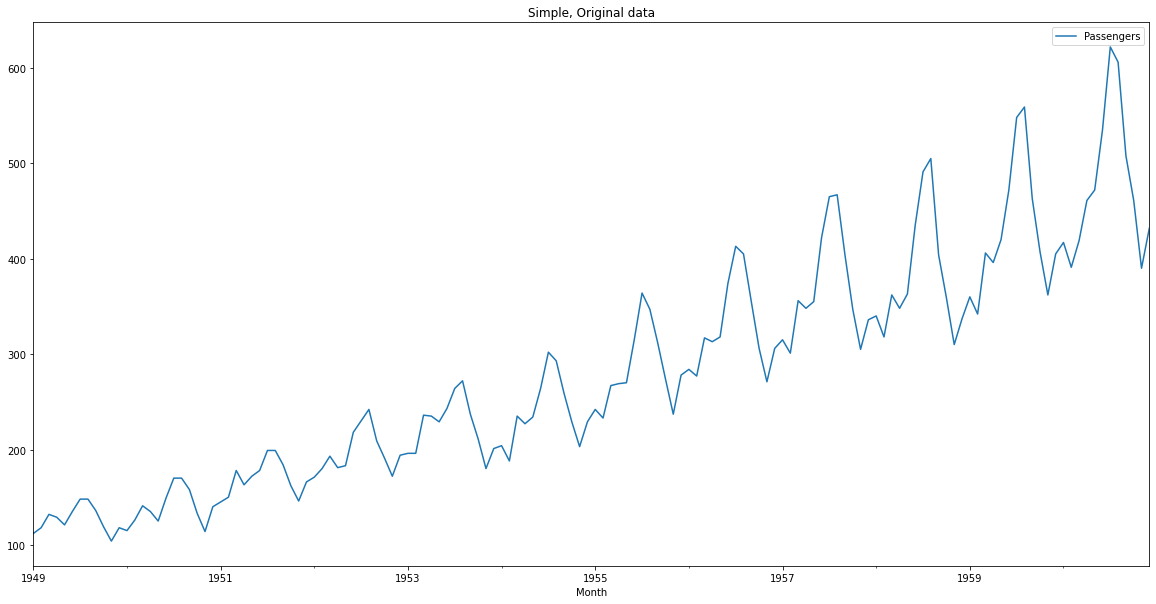

In [22]:
df.plot()
plt.title("Simple, Original data");

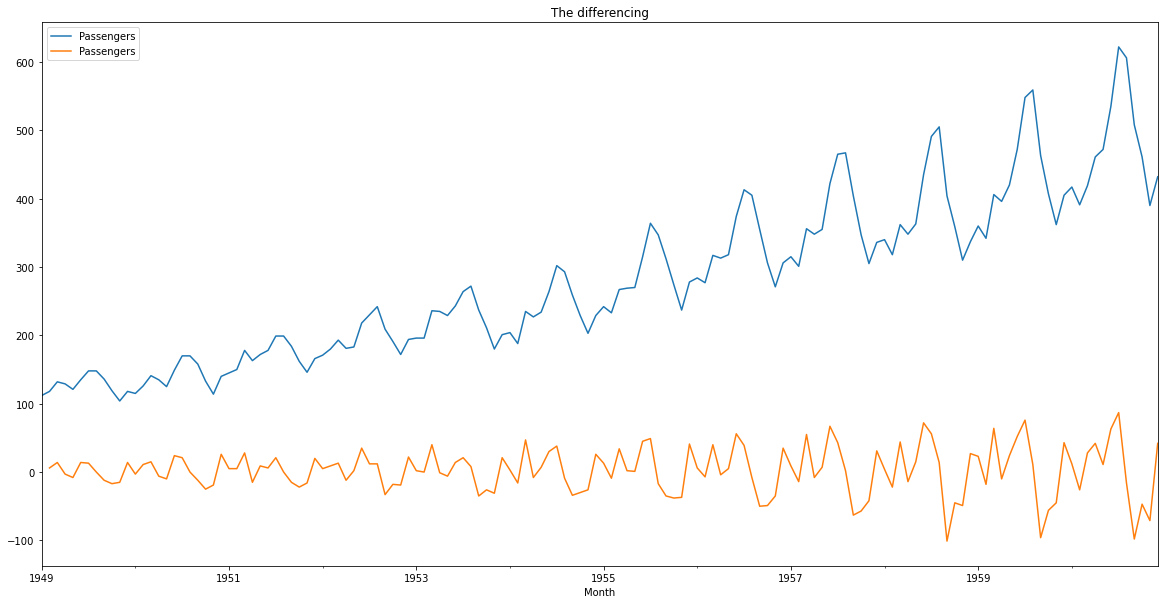

In [23]:
# differencing only
ax = plt.axes()
df.plot(ax=ax)
df.diff().plot(ax=ax)
plt.title("The differencing");

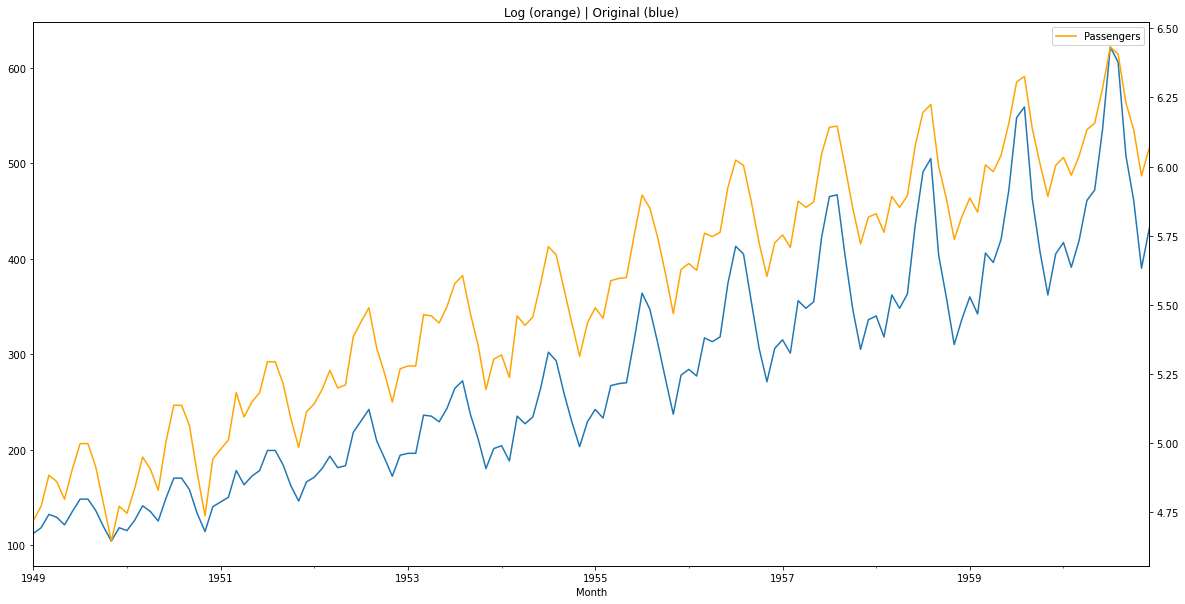

In [24]:
# differencing only
ax = plt.axes()
df.plot(ax=ax, label="original")

ax2 = ax.twinx()
df.apply(np.log).plot(ax=ax2, color='orange', label="log(original)")
plt.title("Log (orange) | Original (blue)");

See the difference? Once more?

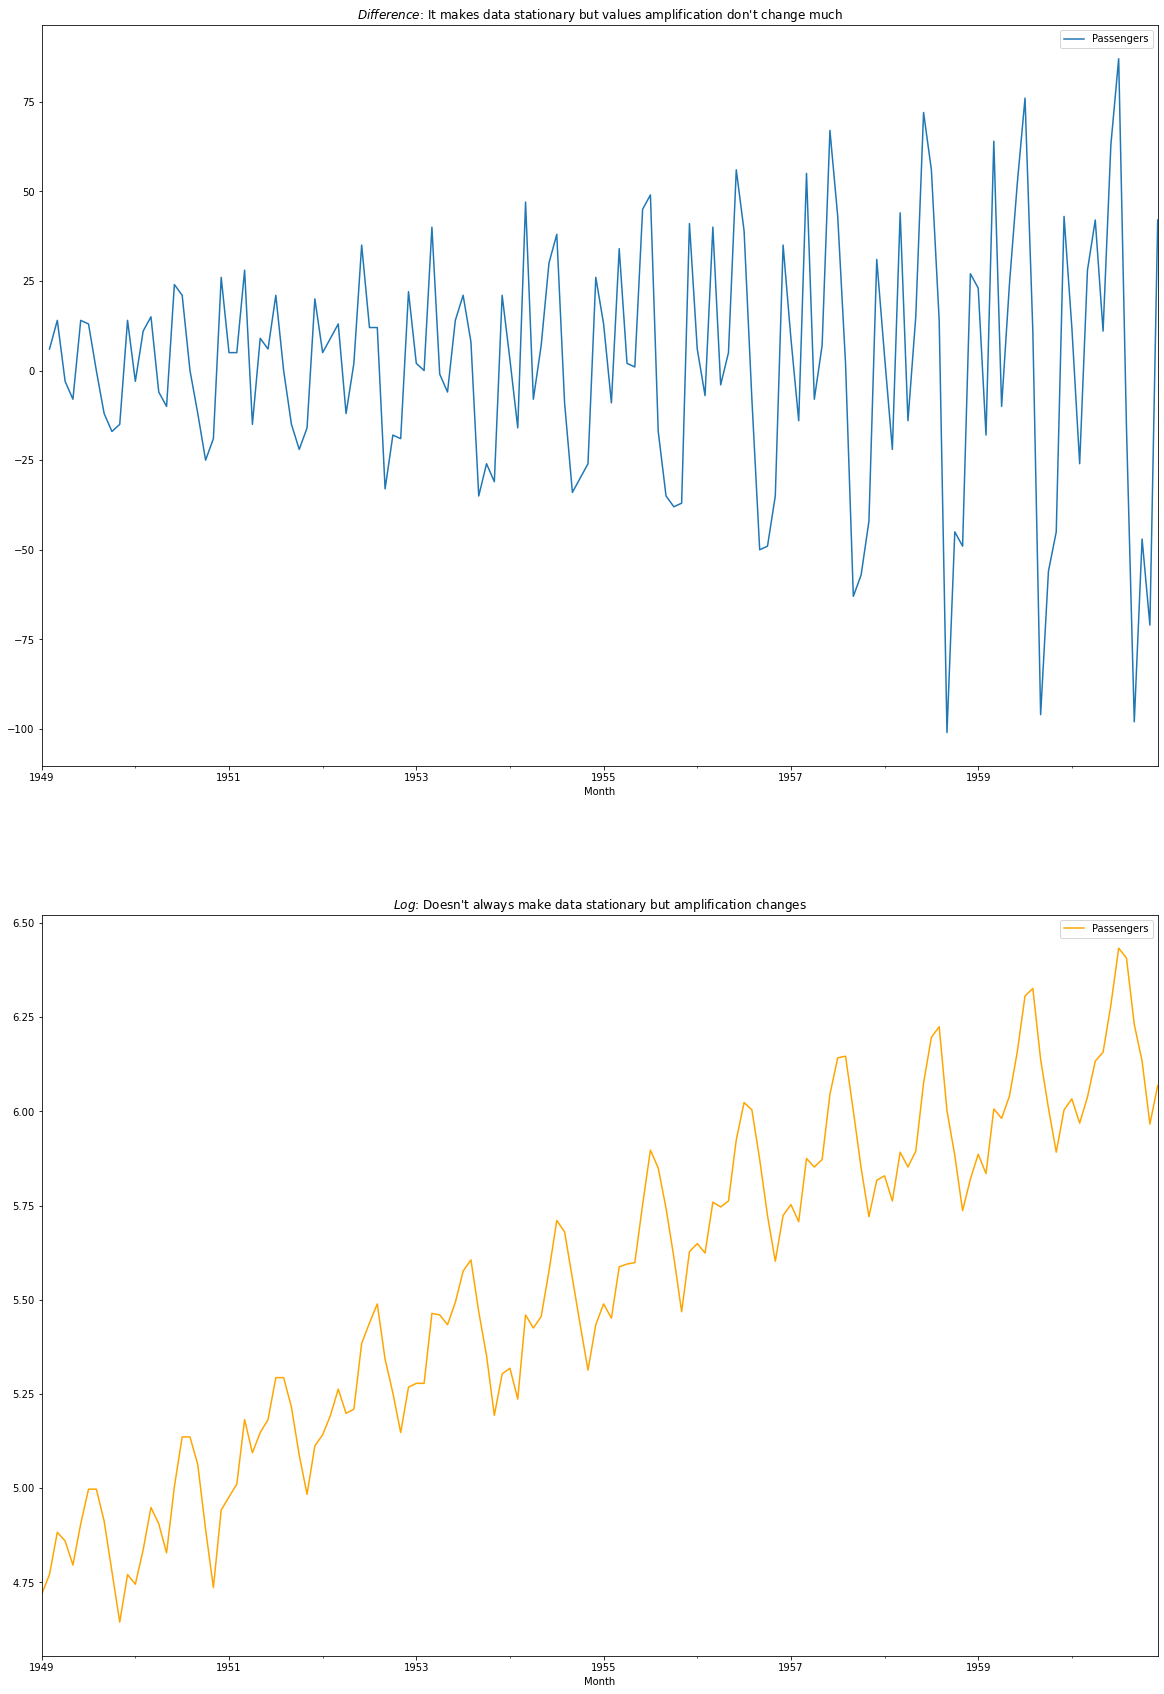

In [25]:
fig, axes = plt.subplots(2, 1, figsize=(20, 30))
df.diff().plot(ax=axes[0])
df.apply(np.log).plot(ax=axes[1], color='orange')

axes[0].set_title("$Difference$: It makes data stationary but values amplification don't change much")
axes[1].set_title("$Log$: Doesn't always make data stationary but amplification changes")
plt.legend();

See? How log has helped us to get the data in kind of straight line?
<br>—<br>
Okay, but what's the point? <br>
The point is:
> *We always don't have to apply ARIMA or any other model on the original data. Sometimes we might also have to use transformations and then apply on that to get better results!*.

So now we will check the same ARIMA model on the transformed data and the orignal data to get the idea which works best.

In [26]:
from sklearn.metrics import mean_squared_error

In [27]:
def rmse(true, pred, is_logged=False):
    if is_logged:
        pred = np.exp(pred)
    return mean_squared_error(true, pred, squared=False)

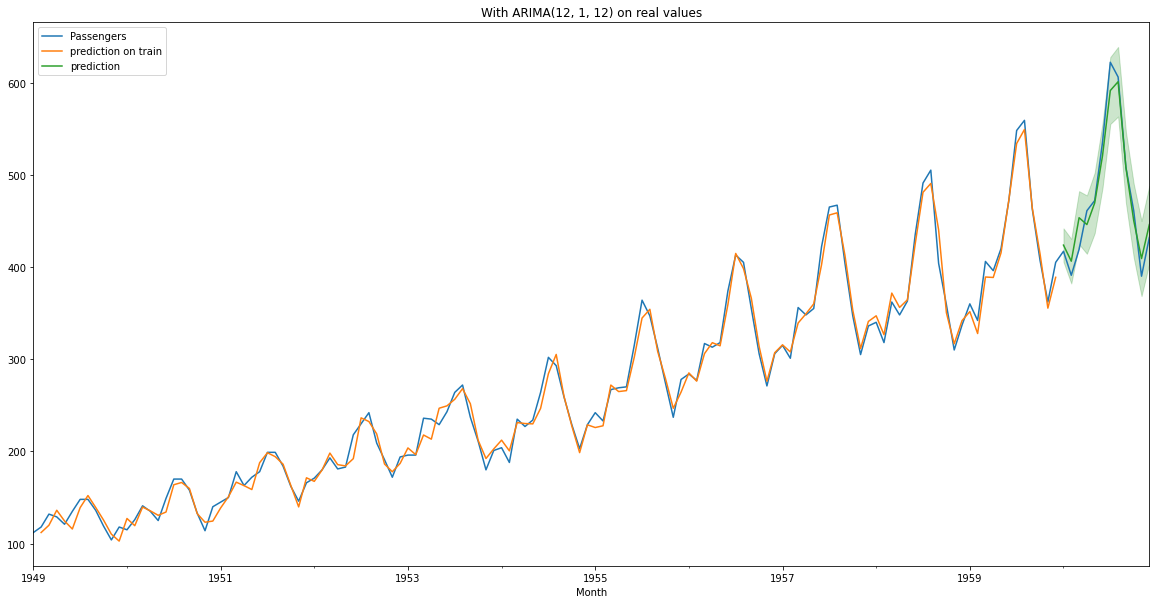

In [28]:
# with real values
arima_real= ARIMA(train, order=(12, 1, 12))
result_real = arima_real.fit()
get_and_plot(result_real, 12, "With ARIMA(12, 1, 12) on real values")

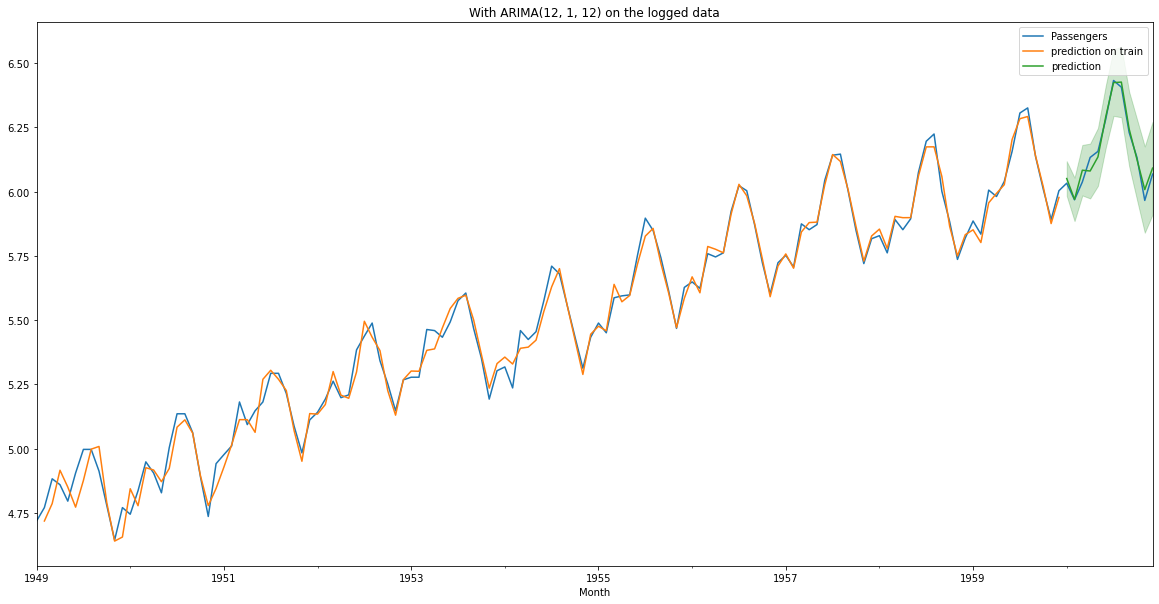

In [29]:
# on the logged data
logged_values = train.apply(np.log)
arima_log = ARIMA(logged_values, order=(12, 1, 12))
result_log = arima_log.fit()
get_and_plot(result_log, h=12, title="With ARIMA(12, 1, 12) on the logged data", original_data=df.apply(np.log))

In [30]:
pred = result_real.forecast(12)
rmse(test, pred, is_logged=False)

17.19570272227581

In [31]:
pred = result_log.forecast(12)
rmse(test, pred, is_logged=True)

12.086964372766184

So, our **log version wins!**

# 

# That was amazing!
Really! Once we get grip on it... we will come back here and train on the stock prices data.